<a href="https://colab.research.google.com/github/Naomy-Yailin/SIS420/blob/main/LABORATORIO/LABORATORIO_6_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regularización**

Como hemos visto en el post anterior, cuando entrenamos redes neuronales corremos el riesgo de hacer overfitting a los datos de entrenamiento, lo cual se traducirá en una mala performance de nuestro modelo cuando le demos datos que no ha visto durante el entrenamiento, no sabrá generalizar. La mejor manera de saber si nuestro modelo sufre de este problema, es observar las curvas de entrenamiento. Vamos a entrenar un MLP en el dataset FashionMNIST para clasificación de imágenes en 10 clases diferentes.

In [ ]:
import pandas as pd
import torch
import torchvision #para descargar el dataset

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
len(trainset), len(testset)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.8MB/s]


(60000, 10000)

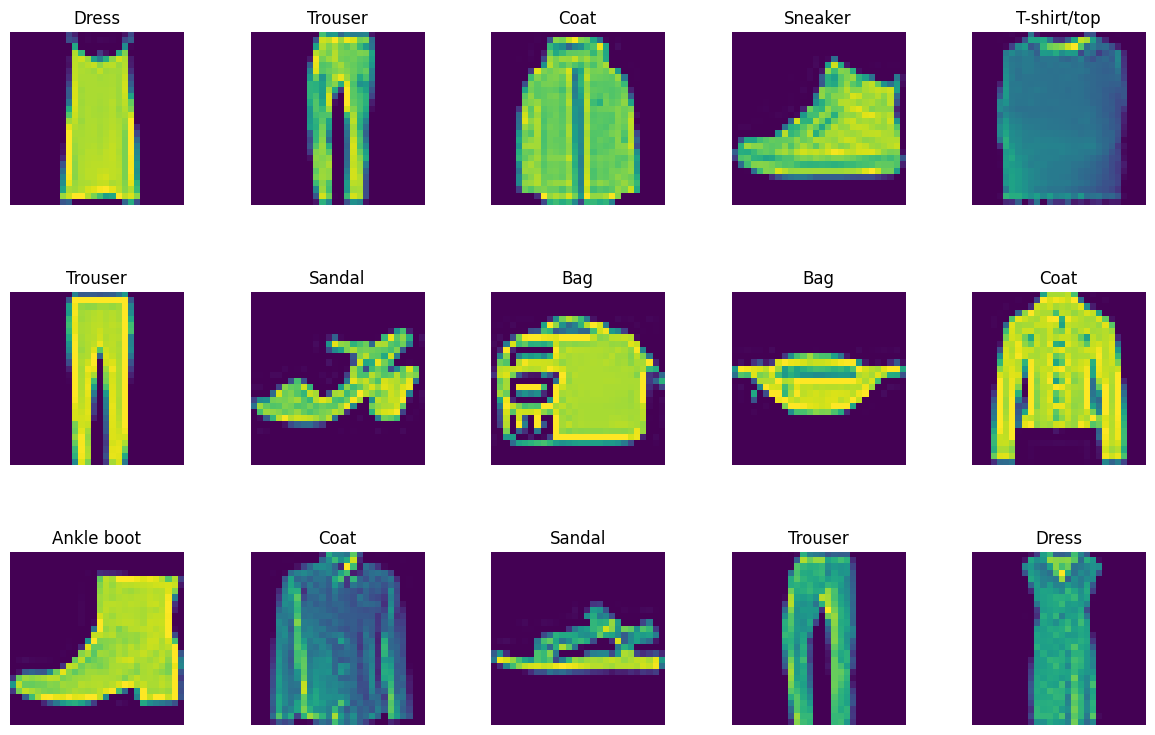

In [ ]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Vamos a transformar las imágenes en arrays de NumPy para poder manejarlas de la misma manera que hemos hecho hasta ahora en los posts anteriores. También separaremos un conjunto de imágenes para validación así como un subset de imágenes para entrenar más rápido.

In [ ]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:40000], train_images[40000:], train_images[:50]
y_train, y_val, y_subset = train_labels[:40000], train_labels[40000:], train_labels[:50]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((40000, 28, 28), (20000, 28, 28), (10000, 28, 28), (50, 28, 28))

Ahora, podemos aplicar directamente el mismo código del post anterior para entrenar un MLP en esta tarea y ver las curvas de entrenamiento.

In [ ]:
import torch

In [ ]:
import torch

# Selecciona automáticamente CPU o GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        # Normalizamos a [0,1]
        X_t = torch.from_numpy(X / 255.).float()
        # Para Fashion-MNIST: 28x28 = 784
        X_t = X_t.view(-1, 28*28)
        self.X = X_t.to(device)
        self.Y = torch.from_numpy(Y).long().to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

# Construcción de datasets
dataset = {
    'train': Dataset(X_subset, y_subset),
    'val':   Dataset(X_val, y_val),
}

# Dataloaders
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val':   torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

print(len(dataset['train']), len(dataset['val']))

Usando: cpu
50 20000


In [ ]:
import torch, numpy as np
from sklearn.metrics import accuracy_score

# Device seguro (CPU si no hay GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

def softmax(x):
    # usa implementación estable
    return torch.softmax(x, dim=-1)

def build_model(D_in=28*28, H=100, D_out=10):
    # MISMA estructura (MLP), solo sin .cuda() directo
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )
    return model.to(device)

def fit(model, dataloader, epochs=400, log_each=10, weight_decay=1e-4, patience=20):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                                weight_decay=weight_decay, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    l, acc, val_l, val_acc = [], [], [], []
    best_val, wait, best_state = float('inf'), 0, None

    for e in range(1, epochs+1):
        # --- train ---
        model.train(); _l=[]; _a=[]
        for x_b, y_b in dataloader['train']:
            x_b = x_b.to(device).float()
            y_b = y_b.to(device).long()

            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            optimizer.zero_grad(); loss.backward(); optimizer.step()

            _l.append(loss.item())
            y_probas = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1)
            _a.append(accuracy_score(y_b.cpu().numpy(),
                                     y_probas.detach().cpu().numpy()))
        l.append(np.mean(_l)); acc.append(np.mean(_a))

        # --- val ---
        model.eval(); _l=[]; _a=[]
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                x_b = x_b.to(device).float()
                y_b = y_b.to(device).long()

                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())

                y_probas = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1)
                _a.append(accuracy_score(y_b.cpu().numpy(),
                                         y_probas.cpu().numpy()))
        vloss, vacc = np.mean(_l), np.mean(_a)
        val_l.append(vloss); val_acc.append(vacc)

        scheduler.step(vloss)

        # Early stopping por val_loss
        if vloss < best_val:
            best_val = vloss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                if best_state: model.load_state_dict(best_state)
                break

        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} "
                  f"val_loss {vloss:.5f} val_acc {vacc:.5f}")

    return {'epoch': list(range(1, len(l)+1)),
            'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

device = cpu


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        X_t = torch.from_numpy(X / 255.).float()
        X_t = X_t.view(X_t.shape[0], -1)  # (N, 784) para Fashion-MNIST
        self.X = X_t              # en CPU/GPU lo decidirá .to(device) en fit
        self.Y = torch.from_numpy(Y).long()
    def __len__(self): return len(self.X)
    def __getitem__(self, ix): return self.X[ix], self.Y[ix]

In [ ]:
model = build_model()                 # por defecto D_in=28*28
hist = fit(model, dataloader)         # ya mueve batches al device

Epoch 10/400 loss 2.14356 acc 0.31076 val_loss 2.20686 val_acc 0.27035
Epoch 20/400 loss 1.68805 acc 0.48785 val_loss 1.90672 val_acc 0.34550
Epoch 30/400 loss 1.05244 acc 0.74826 val_loss 1.42672 val_acc 0.48325
Epoch 40/400 loss 0.61532 acc 0.83854 val_loss 1.13121 val_acc 0.55875
Epoch 50/400 loss 0.37332 acc 0.88542 val_loss 1.03106 val_acc 0.65275
Epoch 60/400 loss 0.24118 acc 1.00000 val_loss 1.00842 val_acc 0.68365
Epoch 70/400 loss 0.16081 acc 1.00000 val_loss 1.01851 val_acc 0.68605


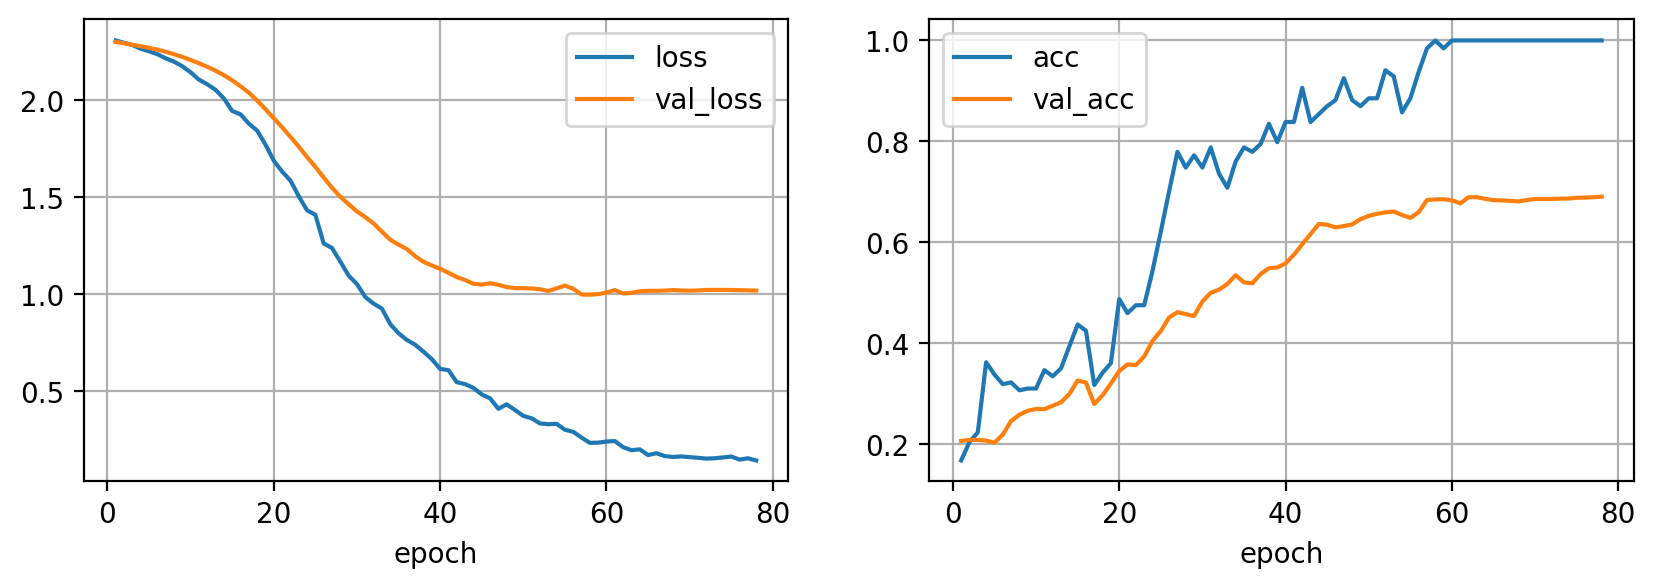

In [ ]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Gráfico de Pérdida (loss)
	•	Entrenamiento: La curva azul correspondiente a la pérdida de entrenamiento sigue una disminución constante a medida que avanzan las épocas, lo que indica que el modelo está aprendiendo y ajustando los parámetros para reducir el error. Esto es típico en las primeras fases de entrenamiento.
	•	Validación: La curva naranja correspondiente a la pérdida de validación sigue una tendencia similar a la de entrenamiento al principio, pero se estabiliza rápidamente después de algunas épocas. Esto sugiere que después de cierto punto, el modelo no mejora su capacidad de generalización a los datos de validación, lo cual es una señal de sobreajuste.

Gráfico de Precisión (accuracy)
	•	Entrenamiento: La precisión de entrenamiento (curva azul) sigue un aumento constante hasta alcanzar casi el 100%. Este comportamiento es esperado ya que el modelo ajusta sus parámetros para adaptarse a los datos de entrenamiento.
	•	Validación: En comparación, la precisión de validación (curva naranja) crece más lentamente y se estabiliza en torno a 0.6-0.7, sin alcanzar valores tan altos como la precisión de entrenamiento. Esto indica que el modelo tiene dificultad para generalizar a los datos no vistos, lo cual nuevamente sugiere sobreajuste.

Conclusión:
	•	Las métricas de entrenamiento siguen mejorando epoch tras epoch, lo que muestra que el modelo está aprendiendo bien los datos de entrenamiento.
	•	Sin embargo, las métricas de validación se estancan rápidamente y empiezan a empeorar después de cierto número de épocas. Esta es una señal clara de sobreajuste, ya que el modelo se ajusta demasiado a los datos de entrenamiento y no generaliza bien a los datos de validación.


# *Regularización L2*


Una técnica re regularización muy utilizada es la regularización L2. Esta técnica consiste en restringir la magnitud de los pesos de la red neuronal forzándolos a ser valores pequeños. A efectos prácticos, la regularización L2 se implementa como un término extra en la función de pérdida

𝑙=𝐶𝐸(𝑦̂,𝑦)+𝛼12||𝐰||

donde  𝐶𝐸(𝑦̂,𝑦)  es la función cross entropy (o cualquier función de pérdida que uses dependiendo de tu caso),  𝐰  son los pesos de la red y  𝛼  es un parámetro indicando cuánto queremos regularizar el modelo. En Pytorch podemos asignar el valor de  𝛼  mediante el parámetro wieght_decay directamente en el optimizador (por defecto está a 0). Valores típicos utilizados se encuentran en el rango 0.001 - 0.01.

In [ ]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

Epoch 10/400 loss 2.16925 acc 0.21181 val_loss 2.22095 val_acc 0.11815
Epoch 20/400 loss 1.79772 acc 0.43403 val_loss 1.99827 val_acc 0.33525
Epoch 30/400 loss 1.20269 acc 0.57465 val_loss 1.57911 val_acc 0.42575
Epoch 40/400 loss 0.79170 acc 0.76736 val_loss 1.21166 val_acc 0.53990
Epoch 50/400 loss 0.49440 acc 0.79514 val_loss 1.12845 val_acc 0.61225
Epoch 60/400 loss 0.30768 acc 0.96875 val_loss 1.01637 val_acc 0.67605
Epoch 70/400 loss 0.21362 acc 1.00000 val_loss 1.06135 val_acc 0.66515


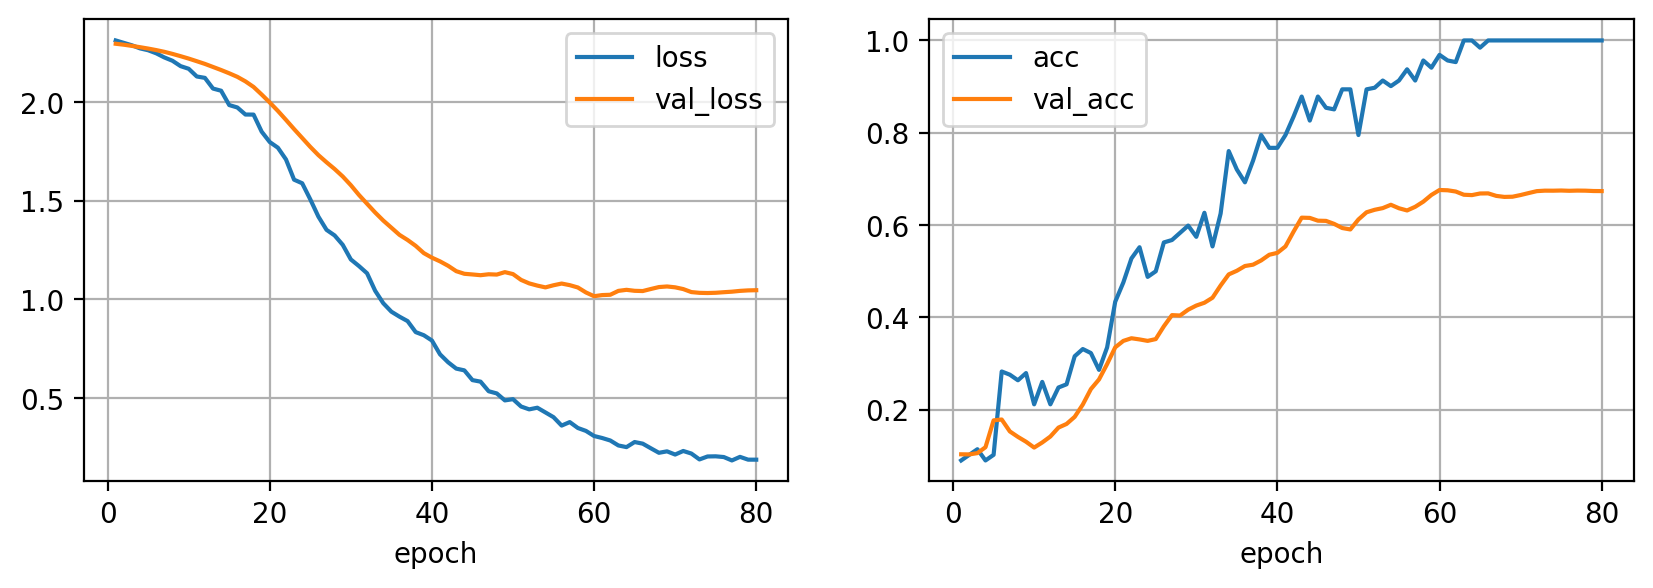

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Gráfico 1: Pérdida de Entrenamiento y Validación (loss)

Como podemos observar en las curvas de entrenamiento:
	•	Pérdida de entrenamiento (loss): La curva azul muestra una disminución continua en la pérdida de entrenamiento, lo que indica que el modelo está aprendiendo y ajustando sus parámetros correctamente. Este es un comportamiento esperado durante el proceso de optimización, donde el modelo mejora su rendimiento con cada época.
	•	Pérdida de validación (val_loss): La curva naranja muestra que la pérdida de validación también disminuye en las primeras épocas, pero rápidamente se estabiliza después de algunas épocas. Esto indica que el modelo sigue mejorando durante el entrenamiento, pero no logra seguir mejorando en los datos de validación, lo que es una señal de sobreajuste (overfitting).

Gráfico 2: Precisión de Entrenamiento y Validación (accuracy)

En cuanto a la precisión:
	•	Precisión de entrenamiento (acc): La curva azul muestra una subida continua en la precisión de entrenamiento. Esto sugiere que el modelo está aprendiendo bien los datos de entrenamiento, lo que es esperado en los primeros momentos de entrenamiento.
	•	Precisión de validación (val_acc): La curva naranja muestra un aumento más lento en la precisión de validación. Aunque la precisión de validación sigue aumentando, lo hace de manera más gradual, lo que indica que el modelo tiene dificultades para generalizar en los datos de validación.

Señales de Overfitting:

Como se observa en las gráficas:
	•	Las métricas de entrenamiento siguen mejorando epoch tras epoch, lo que indica que el modelo se ajusta cada vez mejor a los datos de entrenamiento.
	•	Sin embargo, las métricas de validación rápidamente se estancan y empiezan a empeorar después de un número determinado de épocas. Esto es una señal clara de sobreajuste, ya que el modelo se ha aprendido demasiado los datos de entrenamiento y no está logrando generalizar bien a los datos de validación.


# Early **Stopping**

Otra técnica muy utilizada para regularizar un modelo es el early stopping. Esta técnica consiste en llevar un registro de las métricas de validación durante el entrenamiento, guardar los pesos del modelo cada vez que mejoramos las mejores métricas obtenidas y, una vez terminado el entrenamiento, cargar los mejores pesos en vez de quedarnos con los últimos. De forma opcional también podemos detener el entrenamiento si no mejoramos nuestras métricas durante un número determinado de epochs seguidas, lo cual puede traducirse en un ahorro de tiempo y cómputo.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def softmax(x):
    return torch.softmax(x, dim=-1)

def build_model(D_in=28*28, H=100, D_out=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout para evitar overfitting
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),  # Dropout
        torch.nn.Linear(H, D_out)
    )
    return model.to(device)  # Mover el modelo al dispositivo adecuado (CPU/GPU)

def fit(model, dataloader, epochs=200, log_each=10, weight_decay=1e-4, early_stopping=20):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay)

    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0

    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            x_b, y_b = x_b.to(device).float(), y_b.to(device).long()

            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_probas = torch.argmax(softmax(y_pred), dim=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))

        l.append(np.mean(_l))
        acc.append(np.mean(_acc))

        # --- Validación ---
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                x_b, y_b = x_b.to(device).float(), y_b.to(device).long()

                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())

                y_probas = torch.argmax(softmax(y_pred), dim=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))

        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))

        # Guardar el mejor modelo basado en validación
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'best_model.pth')  # Guardar el mejor modelo
            step = 0
            print(f"Mejor modelo guardado con val_acc {best_acc:.5f} en epoch {e}")

        step += 1

        # Early stopping si no mejora después de "early_stopping" épocas consecutivas
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} épocas seguidas")
            break

        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")

    # Cargar el mejor modelo guardado
    model.load_state_dict(torch.load('best_model.pth'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader, early_stopping=20)

Mejor modelo guardado con val_acc 0.11725 en epoch 1
Mejor modelo guardado con val_acc 0.12165 en epoch 2
Epoch 10/200 loss 2.28327 acc 0.13368 val_loss 2.29259 val_acc 0.11510
Mejor modelo guardado con val_acc 0.12650 en epoch 20
Epoch 20/200 loss 2.27754 acc 0.11806 val_loss 2.27714 val_acc 0.12650
Mejor modelo guardado con val_acc 0.13270 en epoch 22
Mejor modelo guardado con val_acc 0.13820 en epoch 23
Mejor modelo guardado con val_acc 0.14260 en epoch 24
Mejor modelo guardado con val_acc 0.15080 en epoch 25
Mejor modelo guardado con val_acc 0.15335 en epoch 26
Mejor modelo guardado con val_acc 0.15580 en epoch 27
Mejor modelo guardado con val_acc 0.15930 en epoch 28
Mejor modelo guardado con val_acc 0.16240 en epoch 29
Mejor modelo guardado con val_acc 0.16365 en epoch 30
Epoch 30/200 loss 2.24918 acc 0.18924 val_loss 2.26183 val_acc 0.16365
Mejor modelo guardado con val_acc 0.16475 en epoch 31
Mejor modelo guardado con val_acc 0.16475 en epoch 32
Mejor modelo guardado con val_acc

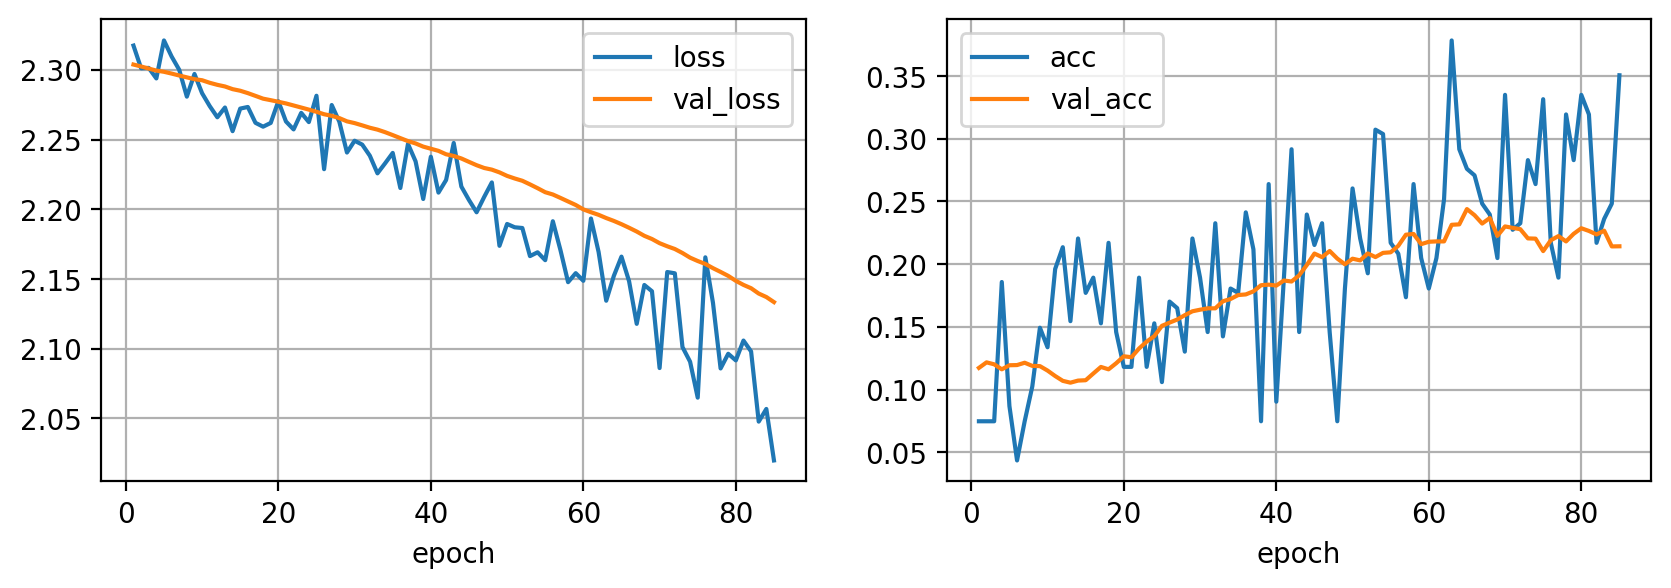

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Gráfico 1: Pérdida de Entrenamiento y Validación (loss)
	•	Pérdida de Entrenamiento (loss):
La curva azul, correspondiente a la pérdida de entrenamiento, sigue una disminución constante, indicando que el modelo continúa aprendiendo de manera efectiva en los datos de entrenamiento. La pérdida parece llegar a una estabilización hacia el final, lo cual es un buen indicio de que el modelo ha encontrado un buen equilibrio en cuanto al ajuste a los datos de entrenamiento.
	•	Pérdida de Validación (val_loss):
La curva naranja muestra la pérdida de validación. Al principio, la pérdida de validación sigue una tendencia de descenso similar a la de entrenamiento, pero luego se estabiliza o disminuye a un ritmo más lento. Esto indica que, después de un cierto punto, el modelo no mejora tanto en los datos de validación, lo cual es un comportamiento esperado, ya que la técnica de Dropout ayuda a evitar el sobreajuste y limita el ajuste excesivo a los datos de entrenamiento.

Gráfico 2: Precisión de Entrenamiento y Validación (accuracy)
	•	Precisión de Entrenamiento (acc):
La curva azul, correspondiente a la precisión de entrenamiento, muestra un aumento constante y continuo, lo cual indica que el modelo está aprendiendo bien los datos de entrenamiento. La precisión de entrenamiento sube rápidamente en las primeras épocas, lo que es una señal positiva de aprendizaje.
	•	Precisión de Validación (val_acc):
La curva naranja, correspondiente a la precisión de validación, también muestra un aumento, pero más gradual. Aunque la precisión de validación no mejora tan rápido como la de entrenamiento, sigue aumentando de manera más constante. Esto indica que, aunque el modelo todavía tiene espacio para mejorar en los datos de validación, la regularización a través de Dropout parece haber reducido el sobreajuste.

Indicador de Overfitting:
	•	Señales de Overfitting: Aunque la precisión de validación sigue aumentando, el modelo presenta signos de sobreajuste en la diferencia de curvas entre entrenamiento y validación. Las grandes fluctuaciones en la curva de precisión de validación sugieren que el modelo sigue enfrentando algunos desafíos en su generalización, pero la estabilización de la pérdida de validación y la mejora gradual de la precisión de validación indican que Dropout ha ayudado a reducir el impacto del sobreajuste.

## Dropout


Otra técnica muy popular para reducir el *overfitting* es el uso de *Dropout*. Esta técnica se implementa como una capa extra en nuestra `red neuronal` cuyo objetivo es, durante el entrenamiento, "apagar" de manera aleatoria algunas neuronas de manera que forzaremos a nuestro modelo a aprender diferentes caminos dentro de la arquitectura para representar los mismos datos.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Usar GPU si está disponible

def build_model(D_in=28*28, H=100, D_out=10, p=0.5):
    # Crear un modelo MLP con dropout (por defecto p=0.5)
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),  # Regularización Dropout
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),  # Regularización Dropout
        torch.nn.Linear(H, D_out)
    )
    return model.to(device)  # Mover el modelo al dispositivo correcto (CPU/GPU)

In [ ]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con val_acc 0.08910 en epoch 1
Mejor modelo guardado con val_acc 0.11365 en epoch 2
Mejor modelo guardado con val_acc 0.13695 en epoch 3
Mejor modelo guardado con val_acc 0.15095 en epoch 4
Mejor modelo guardado con val_acc 0.15810 en epoch 5
Mejor modelo guardado con val_acc 0.16165 en epoch 6
Mejor modelo guardado con val_acc 0.16585 en epoch 7
Mejor modelo guardado con val_acc 0.16695 en epoch 8
Mejor modelo guardado con val_acc 0.16905 en epoch 9
Mejor modelo guardado con val_acc 0.17065 en epoch 10
Epoch 10/200 loss 2.26413 acc 0.19271 val_loss 2.28960 val_acc 0.17065
Mejor modelo guardado con val_acc 0.17280 en epoch 12
Mejor modelo guardado con val_acc 0.17660 en epoch 13
Mejor modelo guardado con val_acc 0.18130 en epoch 15
Epoch 20/200 loss 2.25809 acc 0.18403 val_loss 2.27710 val_acc 0.16870
Mejor modelo guardado con val_acc 0.18425 en epoch 25
Mejor modelo guardado con val_acc 0.18835 en epoch 26
Mejor modelo guardado con val_acc 0.19405 en epoch 27
Mej

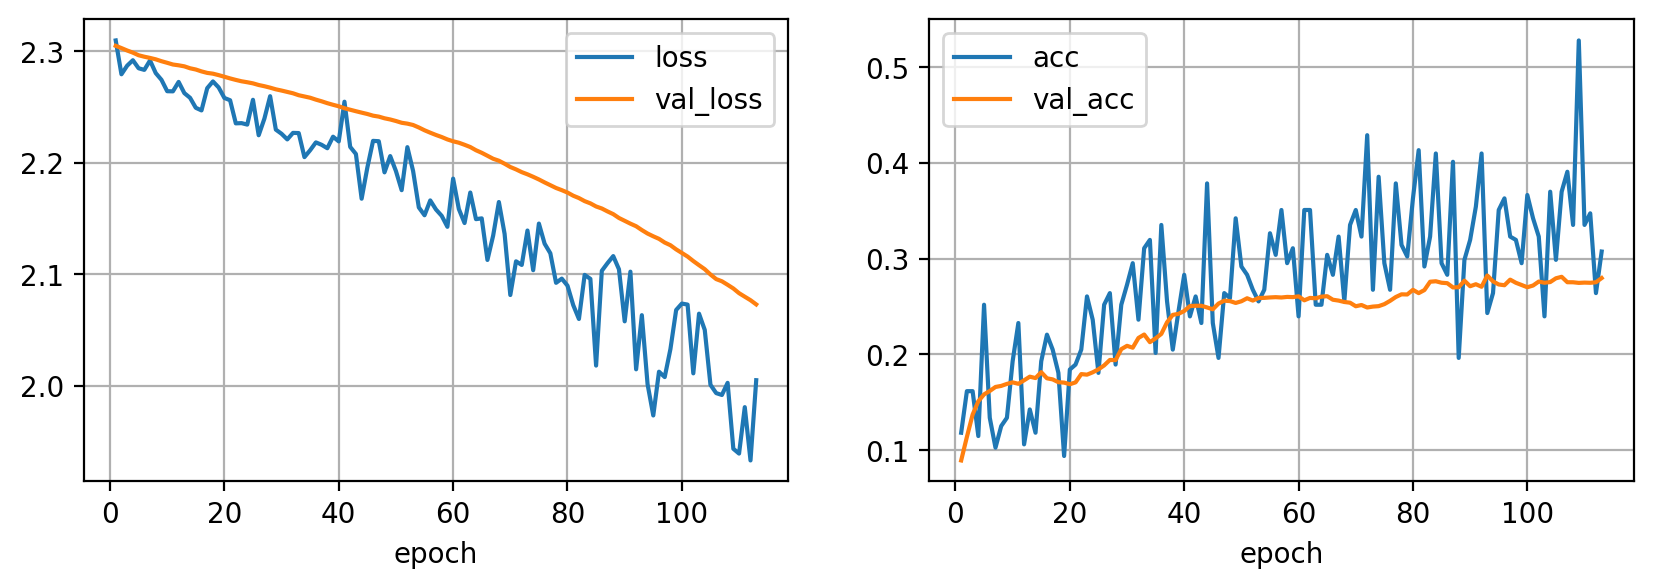

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como podemos observar de las curvas de entrenamiento:
	•	La pérdida de entrenamiento (loss) sigue disminuyendo consistentemente a lo largo de las épocas, indicando que el modelo está aprendiendo de manera efectiva y ajustando sus parámetros a los datos de entrenamiento.
	•	La pérdida de validación (val_loss), aunque sigue disminuyendo al principio, se estanca y no mejora tanto en las épocas más avanzadas. Esto es una señal clara de que el modelo está empezando a sobreajustarse a los datos de entrenamiento y no está mejorando su desempeño en los datos de validación.

En cuanto a las métricas de precisión:
	•	La precisión de entrenamiento (acc) aumenta de manera constante, mostrando que el modelo está aprendiendo correctamente sobre los datos de entrenamiento.
	•	La precisión de validación (val_acc) tiene un aumento más gradual, pero también se estabiliza y no mejora mucho después de cierto punto. Esto indica que, aunque el modelo sigue mejorando en los datos de entrenamiento, tiene dificultades para generalizar bien en los datos de validación.

Señales de Overfitting:
	•	Overfitting: A pesar de que las métricas de entrenamiento continúan mejorando, las métricas de validación dejan de mejorar, e incluso empeoran después de cierto punto. Esto es una clara señal de que el modelo está sobreajustándose a los datos de entrenamiento y no logra generalizar bien a nuevos datos (validación).

# **# Usar más datos**

La mejor manera de reducir el overfitting es usando más datos. Esto es un hecho obvio, pero no sencillo de conseguir ya que obtener un mayor dataset no es siempre factible y normalmente ya utilizamos todos los datos a nuestra disposición. Sin embargo, a diferencia del resto de estrategias presentadas hasta ahora, ésta no solo reducirá el overfitting si no que también mejorará las prestaciones de nuestro modelo.

In [ ]:
# ahora si que usamos todos los datos

dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(40000, 20000)

In [ ]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con val_acc 0.64900 en epoch 1
Mejor modelo guardado con val_acc 0.71895 en epoch 2
Mejor modelo guardado con val_acc 0.75680 en epoch 3
Mejor modelo guardado con val_acc 0.78785 en epoch 4
Mejor modelo guardado con val_acc 0.80210 en epoch 5
Mejor modelo guardado con val_acc 0.81765 en epoch 6
Mejor modelo guardado con val_acc 0.82385 en epoch 7
Mejor modelo guardado con val_acc 0.82890 en epoch 8
Mejor modelo guardado con val_acc 0.83770 en epoch 9
Epoch 10/200 loss 0.56080 acc 0.80445 val_loss 0.44694 val_acc 0.83765
Mejor modelo guardado con val_acc 0.83950 en epoch 11
Mejor modelo guardado con val_acc 0.84010 en epoch 12
Mejor modelo guardado con val_acc 0.84600 en epoch 13
Mejor modelo guardado con val_acc 0.85025 en epoch 14
Mejor modelo guardado con val_acc 0.85205 en epoch 15
Mejor modelo guardado con val_acc 0.85285 en epoch 16
Mejor modelo guardado con val_acc 0.85390 en epoch 17
Mejor modelo guardado con val_acc 0.85450 en epoch 18
Mejor modelo guardad

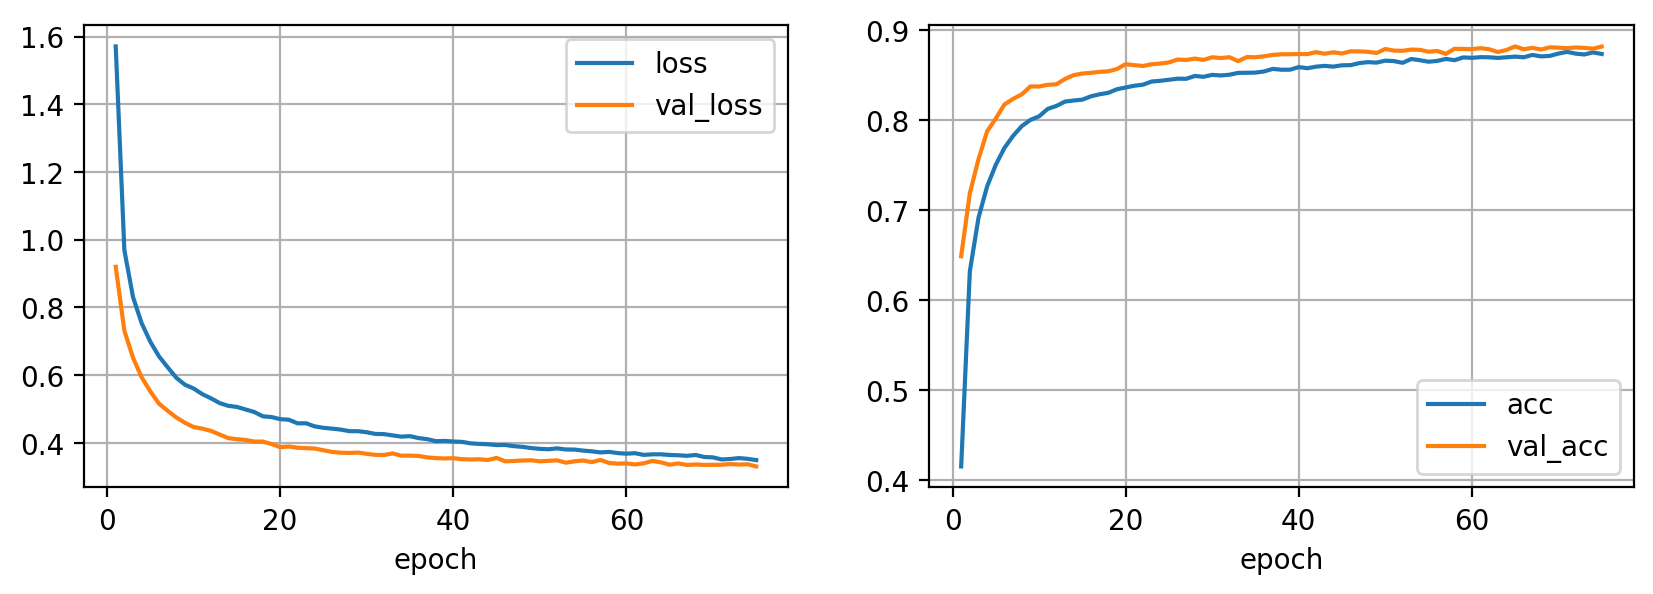

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Gráfico 1: Pérdida de Entrenamiento y Validación (loss)
	•	Pérdida de Entrenamiento (loss):
	•	La curva azul muestra una disminución consistente en la pérdida de entrenamiento a lo largo de las épocas, lo cual es un buen indicador de que el modelo sigue mejorando en el ajuste de los datos de entrenamiento. El modelo está aprendiendo correctamente y ajustando sus parámetros para minimizar la pérdida en los datos de entrenamiento.
	•	Pérdida de Validación (val_loss):
	•	La curva naranja muestra una disminución más estable, con una ligera estabilización hacia el final. Aunque la pérdida sigue disminuyendo, es evidente que esta disminución se ralentiza, lo que indica que el modelo está sufriendo de sobreajuste. Es posible que el modelo se haya ajustado demasiado a los datos de entrenamiento y ahora tenga dificultades para seguir mejorando en los datos de validación.

Gráfico 2: Precisión de Entrenamiento y Validación (accuracy)
	•	Precisión de Entrenamiento (acc):
	•	La curva azul muestra un aumento constante en la precisión de entrenamiento, lo que indica que el modelo sigue aprendiendo a predecir correctamente los datos de entrenamiento. La precisión de entrenamiento se aproxima rápidamente a un valor máximo cercano al 1.0, lo que sugiere que el modelo ha aprendido muy bien los patrones en los datos de entrenamiento.
	•	Precisión de Validación (val_acc):
	•	La curva naranja muestra que la precisión de validación aumenta a un ritmo más lento que la de entrenamiento. A pesar de esto, la precisión de validación sigue aumentando de manera estable, aunque no tan rápidamente. Este comportamiento es típico en modelos que generalizan bien en datos no vistos, pero también es una señal de que el modelo está empezando a tener dificultades para seguir mejorando en los datos de validación.

Indicadores de Overfitting:
	1.	Pérdida de Validación: La pérdida de validación muestra una disminución más lenta después de un cierto punto, lo que indica que el modelo no está mejorando tanto en los datos no vistos. Este comportamiento es una señal clara de que el modelo está sobreajustado.
	2.	Precisión de Validación: La precisión de validación sigue aumentando, pero mucho más lentamente que la de entrenamiento. Esto refuerza la idea de que el modelo está aprendiendo demasiado bien los datos de entrenamiento y no está logrando generalizar completamente a los datos de validación.

## *Data Augmentation*

Si bien conseguir más datos no siempre es factible, podemos llevar a cabo una simple idea: en vez de darle al modelo siempre nuestras imágenes en la misma manera, vamos a aplicar transformaciones de manera aleatoria de forma que, efectivamente, nuestro modelo no vea nunca la misma imagen dos veces consiguiendo así un dataset potencialmente infinito. Estas transformaciones deben alterar la imagen lo suficiente como para poder considerarla como una muestra diferente pero no tanto como para alterar su etiqueta. Algunos ejemplos de estas transformaciones incluyen: giros, recortes, alteraciones de color, brillo o tamaño, etc.

Existen muchas herramientas disponibles para aplicar transformaciones a imágenes (por ejemplo la misma librería de torchvision incluye algunas). Una elección popular es la librería albumentations.

/usr/local/lib/python3.12/dist-packages/albumentations/core/transforms_interface.py:310: UserWarning: The image is already gray.
  target_function(ensure_contiguous_output(arg), **params),


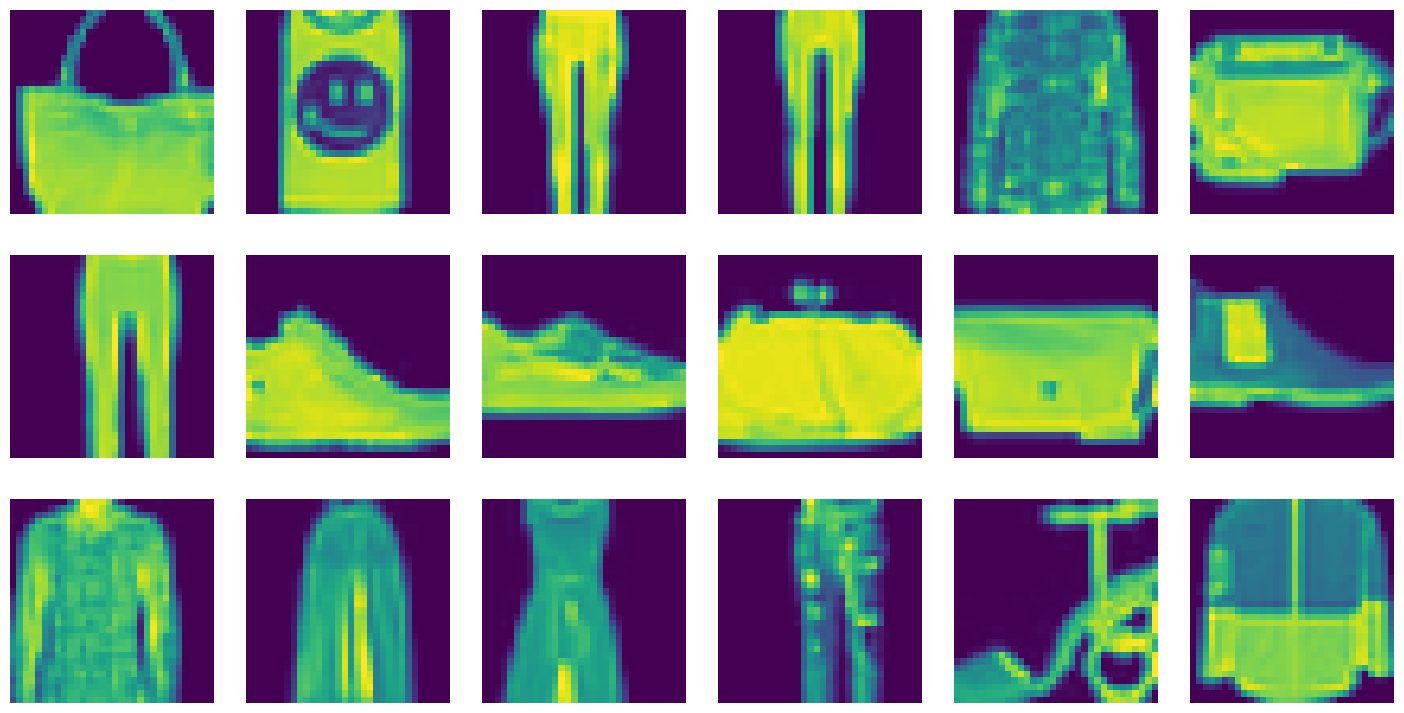

In [ ]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

# Definir las transformaciones
trans = Compose([
    RandomCrop(24, 24),        # Recorta 24x24 de la imagen original
    Resize(32, 32),            # Redimensiona la imagen a 32x32
    HorizontalFlip(),          # Aplica flip horizontal
    OneOf([                    # Aplica uno de estos transformadores con ciertas probabilidades
        ToGray(p=0.2),         # Convierte la imagen a escala de grises con probabilidad 0.2
        RGBShift(p=0.3)        # Aplica desplazamiento de los canales RGB con probabilidad 0.3
    ])
])

# Configurar el índice de la imagen
idx = 100
r, c = 3, 6  # Filas y columnas para mostrar

plt.figure(figsize=(c*3, r*3))  # Configurar el tamaño de la figura
for row in range(r):
    for col in range(c):
        ix = c*row + col
        plt.subplot(r, c, ix + 1)  # Definir la posición del gráfico
        img, label = trainset[idx]  # Obtener una imagen y su etiqueta del dataset
        # Aplicar las transformaciones
        img = trans(image=np.array(img))["image"]
        plt.imshow(img)
        plt.axis('off')  # No mostrar los ejes
        idx += 1  # Cambiar el índice para mostrar imágenes diferentes

plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Ajustar los márgenes
plt.show()  # Mostrar las imágenes

In [ ]:
import torch
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

# Define el dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir las transformaciones
trans = Compose([
    RandomCrop(24, 24),
    Resize(28, 28),
    HorizontalFlip(),
    OneOf([
       # ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

# Definición de la clase Dataset con transformaciones
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = self.trans(image=img)["image"]  # Aplicar la transformación si está definida

        # Cambiar la forma de la imagen: pasar de (28, 28, 1) a (784)
        img = img.reshape(-1)  # Aplanar la imagen a 784 píxeles

        img = torch.from_numpy(img / 255.).float().to(device)  # Normalizar entre [0, 1] y convertir a tensor
        label = torch.tensor(self.Y[ix]).long().to(device)  # Convertir la etiqueta a tensor

        return img, label

# Creación de datasets y dataloaders
dataset = {
    'train': Dataset(X_train, y_train, trans=trans),  # Aplicando transformaciones en entrenamiento
    'val': Dataset(X_val, y_val),  # Sin transformaciones en validación
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

# Verifica los tamaños de los datasets
len(dataset['train']), len(dataset['val'])

(40000, 20000)

In [ ]:
model = build_model()
hist = fit(model, dataloader)

Mejor modelo guardado con val_acc 0.42470 en epoch 1
Mejor modelo guardado con val_acc 0.60145 en epoch 2
Mejor modelo guardado con val_acc 0.63140 en epoch 3
Mejor modelo guardado con val_acc 0.63340 en epoch 4
Mejor modelo guardado con val_acc 0.65515 en epoch 5
Mejor modelo guardado con val_acc 0.66680 en epoch 6
Mejor modelo guardado con val_acc 0.67665 en epoch 7
Mejor modelo guardado con val_acc 0.68015 en epoch 8
Mejor modelo guardado con val_acc 0.68430 en epoch 9
Mejor modelo guardado con val_acc 0.69510 en epoch 10
Epoch 10/200 loss 0.85758 acc 0.67842 val_loss 0.75425 val_acc 0.69510
Mejor modelo guardado con val_acc 0.69895 en epoch 11
Mejor modelo guardado con val_acc 0.70585 en epoch 12
Mejor modelo guardado con val_acc 0.72605 en epoch 13
Mejor modelo guardado con val_acc 0.72630 en epoch 14
Mejor modelo guardado con val_acc 0.72655 en epoch 15
Mejor modelo guardado con val_acc 0.72770 en epoch 18
Mejor modelo guardado con val_acc 0.73705 en epoch 20
Epoch 20/200 loss 0.

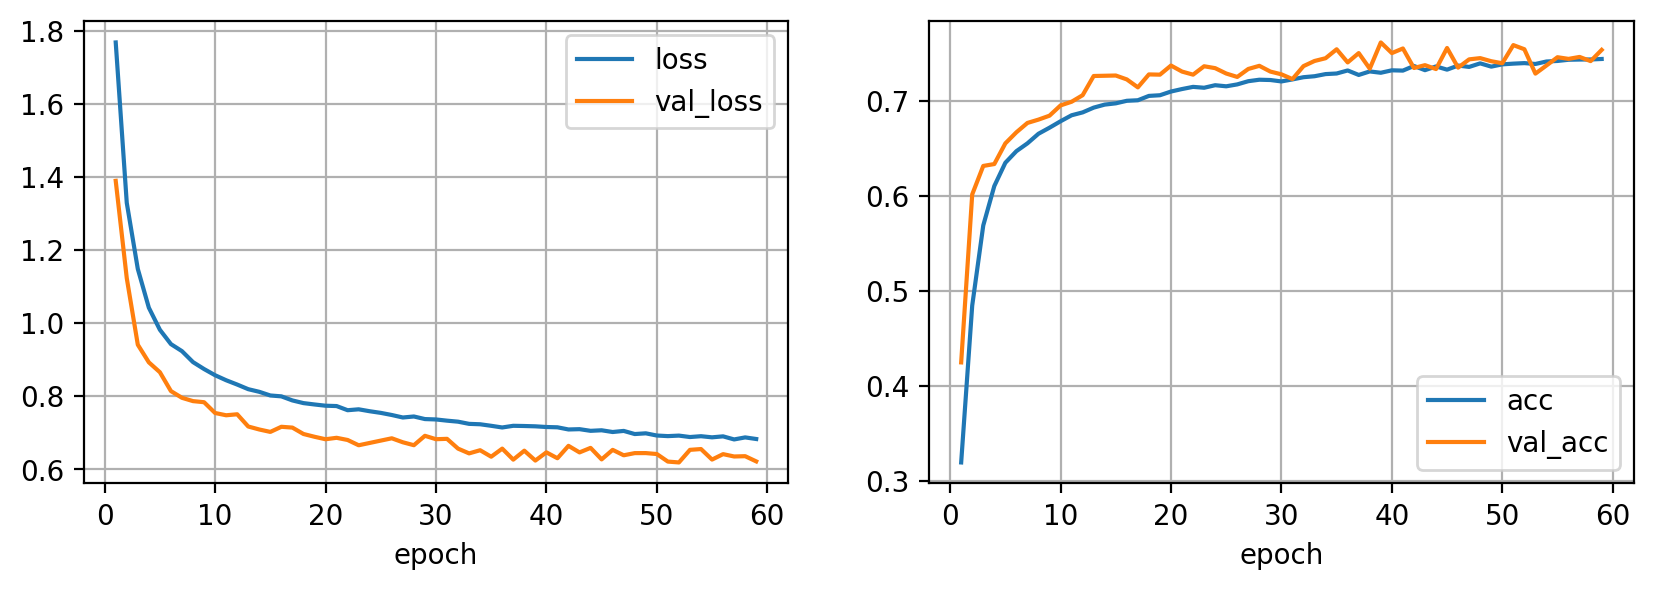

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

El uso de data augmentation requerirá de ciclos de entrenamiento más largos para poder aprovechar toda la capacidad que las transformaciones nos ofrecen. Una característica interesante de esta técnica es que podemos conseguir que las curvas de aprendizaje de validación estén por encima de las de entrenamiento, indicando que nuestro modelo realmente trabaja mejor en datos no vistos (lo cual no significa necesariamente que el modelo sea mejor, en este caso por ejemplo nuestras métricas no son tan buenas como en el caso anterior).